# Overview

In this notebook we implement the Attentive Recurrent Comparator, or ARC [P. Shyam, et. al.](https://arxiv.org/abs/1703.00767), for 20-way one shot classification on the Omniglot dataset. 

The authors report 97.75% accuracy for Within Alphabet classification, we were able to report 75% (+/- 3%) accuracy in a similar set-up, for several hundred one-shot classifications over the entire test set. For an alphabet in the wild, we can expect ARC to complete 20-way one-shot classification with 76.1% (+/- 6.4%) accuracy. We conclude that the implemented model has grasped the ability to discriminate between simple visual concepts fairly well.    

To run the model, please follow these steps:

0. update pytorch to 0.4.1. Do this if you have conda:
    - conda config --add channels soumith
    - conda update pytorch torchvision
1. download the current repo 
2. [download omniglot.npy and omniglot_strokes.npz from here and place it under ./data/](https://drive.google.com/drive/folders/1uGDPpuOy-PXm-Mif3mrnUewGJthkP79A?usp=sharing)
    - omniglot.npy is equivalent to vertically stacking the background and evaluation datasets from Brendan Lake's Omniglot repo
3. run:
   python ARC/train.py --name model
   
   to continue training and read classification accuracies on test set.

Disclaimer: due to the nuanced training regime for models trained on Omniglot data, batcher.py file is inherited then modified from the original [Attentive Recurrent Comparator github repo](https://github.com/pranv/ARC). Besides refactoring existing code, a new test batcher to simulate 20-way one shot classification was added.       

# Exploration
The core strength behind modern Machine Learning is its ability to turn complex, high dimensional data into numbers, e.g. visual, audio, text, etc., and relate examples to one another in a continuous representation. But it is constrained by the quantity of data from which it can learn an internal representation. In domains like biology and healthcare, data is often scarce and the human expertise costly.

The main relevance of Omniglot to machine learning is its small number of examples (drawings produced by humans) for a large number of 'concepts' (characters belonging to different languages). The insight behind our approach is: instead of encoding the few observations to one potentially sparse embedding, create a partial representation between a pair of observations that is iteratively conditioned on their details. This is a fine-grained approach to our particular classification task.  

In the next sections, we motivate our data augmentation process, and the complexity of our model. 

## Number of Strokes and Stroke length

First let's look at aggregate statistics about strokes that make up Omniglot characters [(stroke data made available here)](https://github.com/hardmaru/sketch-rnn-datasets/tree/master/omniglot). Below are histograms of number of strokes and stroke length for all alphabets. We see that ~75% of characters consist of 1-3 strokes. The majority of strokes contain 400-700 pixels. 

### Omniglot is more complex than MNIST + motivation for Image Augmentation

Due to the scarcity of Omniglot data, data augmentation is an indispensable aspect of this challenge. Synthetic samples generated from data augmentation should be indistinguishable from real samples to the human viewer. In this sense, flipping, rotating and small translation of the characters (or a combination of the operations) are valid augmentation techniques; since to humans, an augmented version of an unknown alphabet probably looks very much like the original.  

Being the 'transpose' of MNIST, Omniglot is similar in the sense that it consists of 1-channel images at fairly low resolutions (as model inputs, samples are resized to 32X32 from 105X105). The two datasets are also different. We conclude that the high dimensional Omniglot manifold is more complex than MNIST, since its stroke length distribution and number of strokes contain greater variance than those of arabic numbers [(comparable MNIST analysis)](http://varianceexplained.org/r/digit-eda/). This fact led me to pick up image augmentation parameters similar to those applied for MNIST for modeling on our Omniglot data (e.g. factors for scaling, rotating, translating character images during training, see batcher.py).    

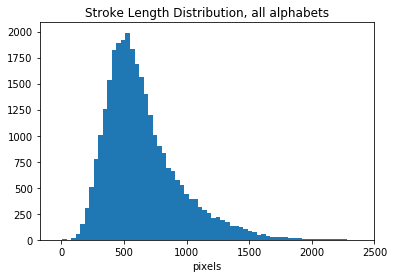

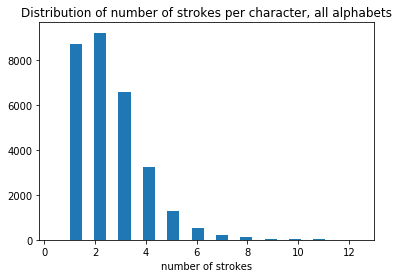

In [1]:
%matplotlib inline
from ARC import * 
from ARC.viz import *

stroke_stats()

## Success with Omniglot is in the details

t-Stochastic Neighborhood Embedding (t-SNE) projects high dimensional data to low dimensions by computing probability distributions bewteen observations. The projection then seeks to preserve the Kullback-Liebler divergence between observations. Structurally, when t-SNE is applied to an alphabet, different drawings of the same/similar characters cluster together. An alphabet called Sylheti's constituent drawings are presented below. 

Notice the concentration of drawings for purple and blue window pane-like characters, located bottom center. Also, the knot/curl-like drawings on center left, and the 'pi'-like drawings on center top.   

From looking closely at the 'pi'-like characters, of which there are red, green, brown and blue, we can immediately conclude that a successful model must be able to pay *attention* to fine details in the strokes. For example, conducting 20-way one-shot classification within Sylheti calls for a model's ability to observe the curvature, as well as orientation of the 'pi' strokes. This serves as motivation for Attentive Recurrent Comparators (ARCs).

From the overall pixel information alone, t-SNE was able to concentrate similar characters into the same regions, but __a few pixels, as in the case of 'the tail' for window-pane characters, make the crucial difference.__

*Because of t-SNE's stochastic nature, please create a new cell to generate new viz*

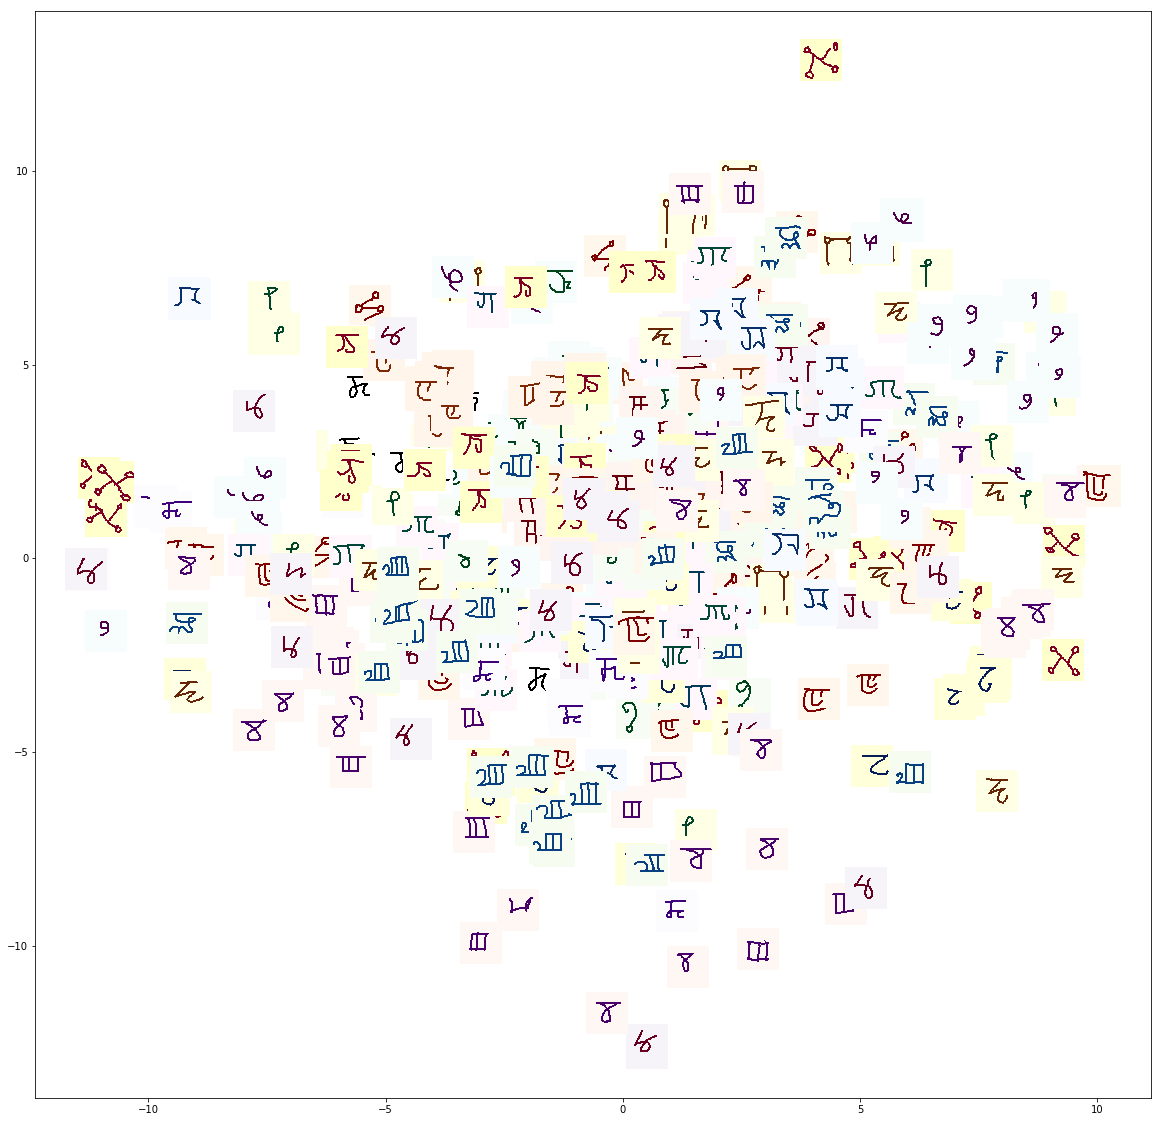

In [4]:
plt.rcParams["figure.figsize"] = (20,20)
tsne_alph(alphabet_index = 45, perp=120)
plt.show()

# Algorithm

A summary of the ARC algorithm is provided here, for model diagram and visualization of how attention works, please see [P. Shyam, et. al.](https://arxiv.org/abs/1703.00767). During both training and evaluation, a batch of image pairs (Image A, Image B) are presented to ARC. The algorithm below describes the function $ ARC_{\theta}(\cdot)$ applied to a single observation, i.e. 

$ ARC_{\theta}( (I_A, I_B) ) = S \left( C(I_A) = C(I_B) \right) $ 

where $\theta$ is the set of model weights learned during training, $(I_A, I_B)$ is the image pair for which ARC assigns a raw score $S$ conveying ARC's confidence that drawings A and B belong to the same character. In the procedure below, mathematical notation is abstracted away and the focus is on the core action of the algorithm.   

1. Image A and Image B are convolved through a convolution layer into 3D solids
    - tensors of shape [ Batch Size X Channels X Width X Height]
<br>
2. A Recurrent Neural Network (RNN) is initiated
    - This RNN alternates between patches of image A and image B during the iterative comparison.
<br>
3. The location and size of a Cauchy kernel grid is computed from information in the current state of the RNN
    - The attention parameters to be applied to the image is computed
4. A patch of Image A is extracted by applying the grid from previous step 
<br>
5. The RNN's hidden state is updated by this image patch 
<br>
6. Repeat steps 3 through 5 for image B
<br>
7. Repeat steps 3 through 6 [ glimpse ] number of times  
    - The glimpse parameter has default value of 8. It is the number of time steps for the RNN, i.e. number of times it considers both images
<br>
8. Send the final RNN hidden state through a linear layer to output a similarity raw score

The raw score is mapped by the logit function to a probability denoting whether the pair $(I_A, I_B)$ belongs to the same character. Using binary cross entropy loss and the Adam optimizer, the gradient after computing the loss of the model is backpropagated through the network to update model weights. 

###### Small note about data loading 

During training, a training batch cannot randomly sample images within alphabet then pair them for input. To do so creates class imbalance especially with alphabets that contain more than 40 characters (>2.5% of labels will be positive). Instead, a training batch is loaded with equal number of matching-character pairs and different-character pairs. During evaluation, a test batch conducts 20-way one-shot classification by pairing copies of the same test image with 20 images in the support set.   



# Model Selection

Key parameters of ARC include Cauchy kernel size, glimpses, hidden size of the RNN controller, and number of convolution filterbanks. For the most part, we follow the parameters provided by the original paper that proposed ARC, the values are respectively 4 X 4, 8, 128 and 16. Cauchy kernel sizes of up to 8 was tried (as opposed to the default value of 4), though the gains have been marginal considering the additional computations incurred. 




## Attention and Glimpses

To better understand what ARC looks for as it glimpses between patches of test and support image, we plot the average similarity score at each glimpse. To construct the bar graph below, we presented 297 trials of 20-way one-shot classification to the model, or 5643 dissimilar pairs images and 297 pairs of images belonging to the same character. Though our model is trained for 8 glimpses, matching the paper parameter, the glimpse statistics below are displaying values for 16 glimpses.

On average, the similarity score starts high and decreases as ARC progresses. ARC assumes the image pair to belong to the same character, then proceeds to look for differences that suggest otherwise. On average, it also converges to a decision by the 8th glimpse, verifying our hyperparameter choice.

The ARC authors have generated compelling visualization for the attention aspect of the model. We know that the attention patch from attending an image is relatively large during early glimpses, then smaller attention patches hone in on the details at later glimpses. This also supports our earlier observation that ARC assumes a pair to belong to the same character until evidence proves otherwise.  

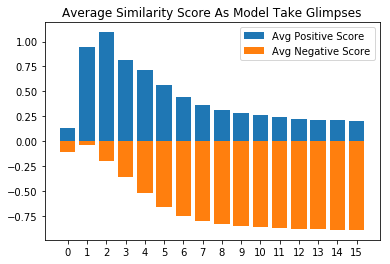

In [2]:
glimpse_stats()
plt.show()

In [1]:
# Great, let's run this model. It's pretty verbose about its performance on the test set, alphabets 30-49.
# Similarity train accuracy: how well it performs on labeling 30 dissimilar pairs and 30 pairs in training set
# NOT 20-way one-shot classification

! python ARC/train.py --name model 

running on 0 devices
training loss: 0.405   similarity train acc: 83    epoch:  0
Alphabet 30 accuracy: 0.827
Alphabet 31 accuracy: 0.710
Alphabet 32 accuracy: 0.737
Alphabet 33 accuracy: 0.807
Alphabet 34 accuracy: 0.733
Alphabet 35 accuracy: 0.753
Alphabet 36 accuracy: 0.850
Alphabet 37 accuracy: 0.900
Alphabet 38 accuracy: 0.620
Alphabet 39 accuracy: 0.737
Alphabet 40 accuracy: 0.747
Alphabet 41 accuracy: 0.797
Alphabet 42 accuracy: 0.767
Alphabet 43 accuracy: 0.753
Alphabet 44 accuracy: 0.880
Alphabet 45 accuracy: 0.713
Alphabet 46 accuracy: 0.817
Alphabet 47 accuracy: 0.763
Alphabet 48 accuracy: 0.537
Alphabet 49 accuracy: 0.810
[0.83, 0.71, 0.74, 0.81, 0.73, 0.75, 0.85, 0.9, 0.62, 0.74, 0.75, 0.8, 0.77, 0.75, 0.88, 0.71, 0.82, 0.76, 0.54, 0.81]


^C
Traceback (most recent call last):
  File "ARC/train.py", line 103, in <module>
    train(loader)
  File "ARC/train.py", line 100, in train
    loss.backward()
  File "/home/mrnood/anaconda3/lib/python3.6/site-packages/torch/tensor.py

# Model Evaluation

The authors report 97.75% accuracy for Within Alphabet, 20-way one-shot classification, we are reporting 75% (+/- 3%) accuracy in this similar set-up, for 1000 one-shot classifications over the entire test set. With more training, it is entirely possible for the model to attain much higher accuracy. 

By conducting 297 classifications within each alphabet, we get a clearer picture for ARC's performance on potential alphabets in the wild.

## Per Alphabet Evaluation

Below, we examine ARC performance across various alphabets. All accuracies are the average of 3 X 99 20-way one-shot trials.


We identify the Tibetan alphabet set to be significantly more difficult to do One Shot classification, at 54.3% accuracy. An explanation for its difficulty is that characters within the alphabet are structurally similar but with minor, important differences, which even ARC did not detect.

For test alphabets that ARC had an easy time to classify (~90% acc), such as Glagolitic, characters were structurally distinct from one another. 

For an alphabet in the wild, we can expect ARC to complete 20-way one-shot classification with 76.1% (+/- 6.4%) accuracy. 

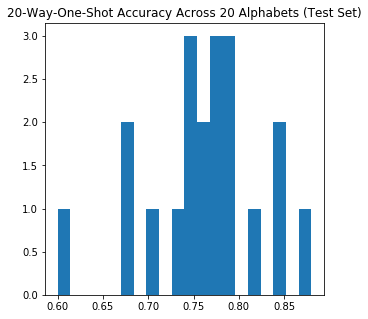

Average Alphabet Accuracy: 0.761     Accuracy Standard Deviation: 0.064 


In [4]:
plt.rcParams["figure.figsize"] = (5,5)
OneShot_EvaluationAlph = [0.77, 0.74, 0.76, 0.78, 0.67, 0.76, 0.85, 0.88, 0.68, 0.73, 0.74, 0.79, 0.79, 0.79, 0.85, 0.71, 0.81, 0.74, 0.6, 0.78]
plt.hist(OneShot_EvaluationAlph, bins = 20)
plt.title('20-Way-One-Shot Accuracy Across 20 Alphabets (Test Set)')
plt.show()
print('Average Alphabet Accuracy: %.3f     Accuracy Standard Deviation: %.3f ' %(np.mean(OneShot_EvaluationAlph), np.std(OneShot_EvaluationAlph)))

While the model has made good progress on this difficult task, a number of improvements can be made:

## Future Work

1. For the first two visualizations in Exploration, stroke data, including stroke direction, was utilized. Unfortunately this  model is not capable of integrating such information, nor can observations of the stroke dataset be linked back to the pixel images themselves. It may be worthwhile to present this information to the RNN controller, perhaps to aid it in making better attention decisions.  

2. During 20-way classification, compute similarity scores between test image and the entire support set at the same time. This may be completed by phrasing the task as a 20-class classification. Currently we are computing raw similarities between  test and support images without considering rest of the support set.    

3. To enhance model interpretbility, for a given character, it may be interesting to identify specific regions or strokes that affected the similarity score of that character across drawings (such as the corner of a turning stroke that ARC consistently attend to), and in this way derive distinctive morphology features.    
